A notebook to compare drift skill in CIOPS-W and SalishSea.

Runs:
* RIOPSBC12nowinds
* CIOPSBC12nowinds
* SalishSeaBC12nowinds

All drift predicitons used Open Drift with no windage. Model drifters were released every 6 hours for a 48 hour duration.

Drifters are 2016 SCTs released by IOS. Grounded drifters were removed manually. 

In [1]:
import glob
import os

import datetime
from matplotlib.pyplot import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import yaml

import driftutils.plotting_utils as putils


%matplotlib inline

In [2]:
comparison_data='/home/soontiensn/data/gpsc-work2/OPP/salish-ciopsw-comparisons/cropped_datasets/RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds/'

In [3]:
polygons_file='/home/soontiensn/data/gpsc-work2/OPP/CTD_analysis_domain_config_template-SalishSea.yml'
with open(polygons_file, 'r') as f:
    polygons = yaml.load(f,Loader=yaml.FullLoader)
polygons

{'depth': [0.0, 10.0, 30.0, 50.0, 100.0, 200.0, 400.0],
 'polygon_coords': {'JdF': [[48.4, -123.6],
   [48.62, -124.7],
   [48.37, -124.7],
   [48.14, -124.0],
   [48.1, -123.5]],
  'Puget': [[48.4, -123.6],
   [48.1, -123.5],
   [48.0, -122.8],
   [48.25, -122.72],
   [48.38, -122.63],
   [48.47, -123.0],
   [48.42, -123.32],
   [48.48, -123.46]],
  'GulfIsl': [[48.47, -123.0],
   [48.38, -122.63],
   [48.5, -122.25],
   [48.85, -122.6],
   [48.7, -122.9],
   [48.965, -123.53],
   [49.18, -123.8],
   [49.2, -124.0],
   [48.4, -123.6],
   [48.48, -123.46],
   [48.67, -123.42],
   [48.67, -123.15]],
  'Haro': [[48.47, -123.0],
   [48.67, -123.15],
   [48.67, -123.42],
   [48.48, -123.46],
   [48.42, -123.32]],
  'SoGN': [[49.34, -123.38],
   [49.41, -123.55],
   [50.0, -124.0],
   [50.2, -125.0],
   [50.0, -125.4],
   [49.4, -124.8],
   [49.2, -124.0],
   [49.18, -123.8]],
  'SoGS': [[48.7, -122.9],
   [48.85, -122.6],
   [49.1, -122.85],
   [49.3, -123.0],
   [49.25, -123.3],
   [49.34

# Binning functions

In [4]:
def grouped_IQR(df, skill):
    """Helper function to group a dataframe and then calculate the interquartile
    range of a skill. The dataframe is grouped by time_since_start.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe must have a time_since_start column which are timedeltas.
    skill : str
        Represents the skill to be analyzed. (e.g. sep, molcard etc)
        
    Returns
    -------
    df_iqr : pandas.DataFrame
        A data frame with the interquartile range grouped by hours since start.
    """
    df_grouped = df.groupby('time_since_start')
    df_iqr = df_grouped.apply(
        lambda x: pd.Series({'25th percentile': x[skill].quantile(0.25),
                             '75th percentile': x[skill].quantile(0.75)}))
    df_iqr = df_iqr.reset_index()
    df_iqr['hours since start'] = df_iqr.time_since_start.astype('timedelta64[h]')
    return df_iqr

# Area functions

In [5]:
def refine_regions(datasets, regions, include=True):
    """Refine data to a set of regions based on initial model position.
    
    datasets = list of datasets to be refined.
    regions  = list of shapely polygons that define regions for analysis.
    
    include=True - the regions will be included in refinement
    include=False - the regions will be excluded from refinement"""
    datasets_refined = []
    for d in datasets:
        model_runs = d.model_run.values
        model_runs_in_region = []
        for m in model_runs:
            start_lat= d.mod_start_lat.values[0, m]
            start_lon = d.mod_start_lon.values[0, m]
            point=Point(start_lat,start_lon)
            for r in regions:
                if r.contains(point):
                    model_runs_in_region.append(m)
                    continue
        if include:
            model_runs_include = model_runs_in_region
        else:
            model_runs_include = [m for m in model_runs if m not in model_runs_in_region]
        dnew = d.sel(model_run=model_runs_include)
        if dnew.model_run.size > 0:
            datasets_refined.append(dnew)
    return datasets_refined

# Regional analysis
Break up into regions. A drifter is included in a region if the model's initial position was in that region.
1. All regions
2. JdF exlcuded (everything but JdF + Puget)
3. JdF ( JdF + Puget)

In [6]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

names = ['SoGS', 'SoGN', 'Howe', 'VH', 'GulfIsl', 'Haro']
names2 = [ 'JdF', 'Puget']

regions = [Polygon(polygons['polygon_coords'][name]) for name in names]
regions_JdF = [Polygon(polygons['polygon_coords'][name]) for name in names2]

In [7]:
files = glob.glob(os.path.join(comparison_data, '*.nc'))
files.sort()
print(files)

['/home/soontiensn/data/gpsc-work2/OPP/salish-ciopsw-comparisons/cropped_datasets/RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds/wp2312547581D20161101_comparison_RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds.nc', '/home/soontiensn/data/gpsc-work2/OPP/salish-ciopsw-comparisons/cropped_datasets/RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds/wp3132544483D20160418_comparison_RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds.nc', '/home/soontiensn/data/gpsc-work2/OPP/salish-ciopsw-comparisons/cropped_datasets/RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds/wp3392541503D20160525_comparison_RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds.nc', '/home/soontiensn/data/gpsc-work2/OPP/salish-ciopsw-comparisons/cropped_datasets/RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds/wp3392541503D20160603_comparison_RIOPSBC12nowinds-CIOPSWBC12nowinds-SalishSeaBC12onowinds.nc', '/home/soontiensn/data/gpsc-work2/OPP/salish-ciopsw-comparisons/cro

In [8]:
datasets_all= []
for f in files:
    d = xr.open_dataset(f)
    datasets_all.append(d)

In [9]:
datasets_no_JdF = refine_regions(datasets_all, regions, include=True)
datasets_JdF = refine_regions(datasets_all, regions_JdF, include=True)

Reorganize

In [10]:
dataset_per_set_all={}
for setname in datasets_all[0].setname.values:
    dataset_per_set_all[setname] = [datasets_all[0].sel(setname=setname),]
    if len(datasets_all) > 1:
        for dataset in datasets_all[1:]:
            dataset_per_set_all[setname].append(dataset.sel(setname=setname))

In [11]:
dataset_per_set_no_JdF={}
for setname in datasets_no_JdF[0].setname.values:
    dataset_per_set_no_JdF[setname] = [datasets_no_JdF[0].sel(setname=setname),]
    if len(datasets_no_JdF) > 1:
        for dataset in datasets_no_JdF[1:]:
            dataset_per_set_no_JdF[setname].append(dataset.sel(setname=setname))

In [12]:
dataset_per_set_JdF={}
for setname in datasets_JdF[0].setname.values:
    dataset_per_set_JdF[setname] = [datasets_JdF[0].sel(setname=setname),]
    if len(datasets_JdF) > 1:
        for dataset in datasets_JdF[1:]:
            dataset_per_set_JdF[setname].append(dataset.sel(setname=setname))

Plotting

In [13]:
def plot_starting_points(ax, bmap, datasets, color='r'):
    point_count=0
    for d in datasets:
        for m in d.model_run.values:
            start_lat = d.sel(model_run=m).mod_start_lat
            start_lon = d.sel(model_run=m).mod_start_lon
            x, y = bmap(start_lon, start_lat)
            ax.plot(x,y,'.', color=color)
            point_count+=1
    return point_count

In [18]:
def plot_skill(skill, datasets, ax, plot_iqr=True):
    n=len(datasets.keys())
    colors_dict = {'RIOPSBC12nowinds': 'blue',
                   'CIOPSWBC12nowinds': 'red',
                   'SalishSeaBC12onowinds': 'purple'}
    for setname, datasets in datasets.items():
        all_mean, all_drifters_all_tracks = putils.bin_skills_all_drifters(datasets, skill)
        if skill == 'sep':
            all_mean[skill] = all_mean[skill]/1000.
            all_drifters_all_tracks[skill] = all_drifters_all_tracks[skill]/1000
        # Exclude initial positions from analysis
        all_drifters_all_tracks = all_drifters_all_tracks[all_drifters_all_tracks['hours since start'] != 0]
        # plotting
        all_mean = all_mean[all_mean['hours since start'] != 0]
        ax.plot(all_mean['hours since start'],
                all_mean[skill],lw=4,
                color=colors_dict[setname],
                label=setname)
        if plot_iqr:
            iqr = grouped_IQR(all_drifters_all_tracks, skill)
            ax.plot(iqr['hours since start'],
                    iqr['25th percentile'],
                    lw=1, color=colors_dict[setname], zorder=0,
                    ls='--', label='__no_legend__')
            ax.plot(iqr['hours since start'],
                    iqr['75th percentile'],
                    lw=1,color=colors_dict[setname], zorder=0,
                    ls='--', label='__no_legend__')
    ax.set_ylabel(skill, fontsize=14)
    ax.set_xlim([0,48])
    ax.legend(fontsize=14)
    ax.grid()
    ax.set_xlabel('hours since start', fontsize=14)

## Review of skill scores
### Separation
Distance between model and observations at any point in time.

### Molcard
$Molcard = max(1 - \frac{d}{D}, 0)$ where d is obs-model separation distance and D is observed displacement.

The Molcard score indicates whether or not the model performs bettern than "last known position". 1 is perfect skill, 0 is no skill.

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'JdF: num points = 359 ')

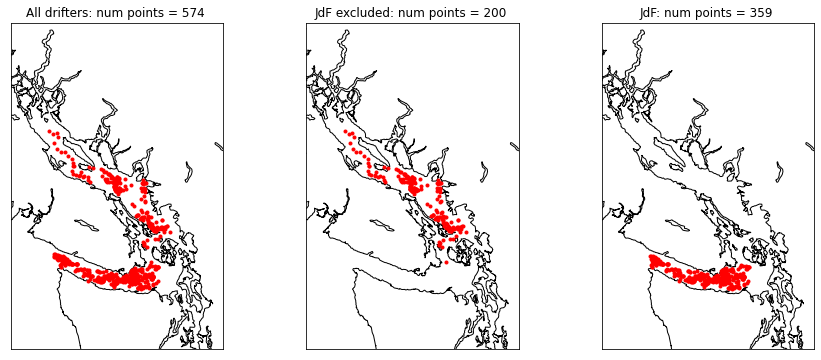

In [15]:
fig,axs = plt.subplots(1,3, figsize=(15,6))
# All
ax=axs[0]
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
point_count = plot_starting_points(ax, m, dataset_per_set_all['RIOPSBC12nowinds'])
m.drawcoastlines()
ax.set_title('All drifters: num points = {} '.format(point_count))
# No JdF
ax=axs[1]
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
point_count=plot_starting_points(ax, m, dataset_per_set_no_JdF['RIOPSBC12nowinds'])
m.drawcoastlines()
ax.set_title('JdF excluded: num points = {} '.format(point_count))
# JdF
ax=axs[2]
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
point_count = plot_starting_points(ax, m, dataset_per_set_JdF['RIOPSBC12nowinds'])
m.drawcoastlines()
ax.set_title('JdF: num points = {} '.format(point_count))

Note that there are a few points at the mouth of JdF that are not within the predefined JdF domain.

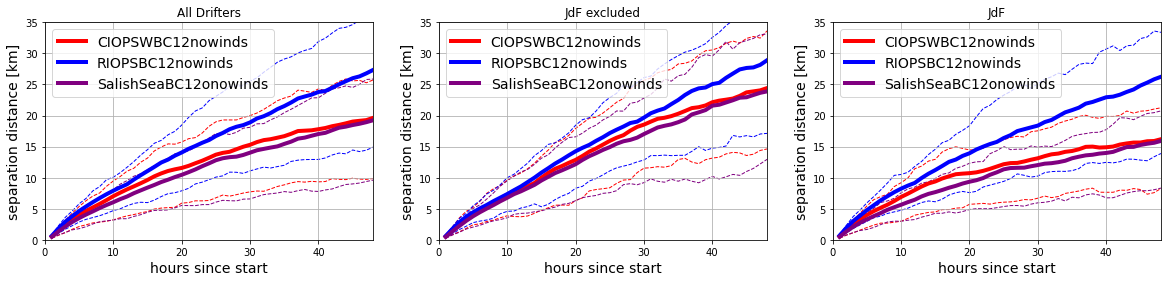

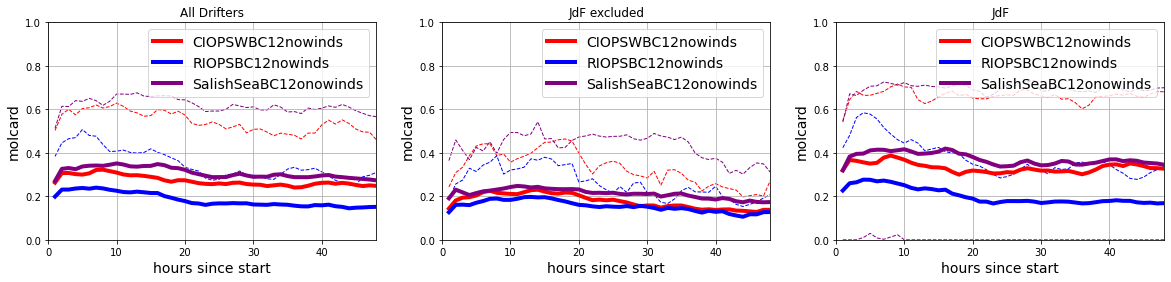

In [19]:
for skill in ['sep', 'molcard']:
    fig,axs=plt.subplots(1,3, figsize=(20,4))
    ax=axs[0]
    plot_skill(skill, dataset_per_set_all, ax)
    ax.set_title('All Drifters')
    ax=axs[1]
    plot_skill(skill, dataset_per_set_no_JdF, ax)
    ax.set_title('JdF excluded')
    ax=axs[2]
    plot_skill(skill, dataset_per_set_JdF, ax)
    ax.set_title('JdF')
    for ax in axs:
        ax.set_ylim([0,1])
        if skill == 'sep':
            ax.set_ylabel('separation distance [km]')
            ax.set_ylim([0,35])



# Individual regions
* Examine skill in each region separately.

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


JdF: num points = 203
Puget: num points = 156
GulfIsl: num points = 6
Haro: num points = 5
SoGN: num points = 111
SoGS: num points = 70
VH: num points = 7
Howe: num points = 1


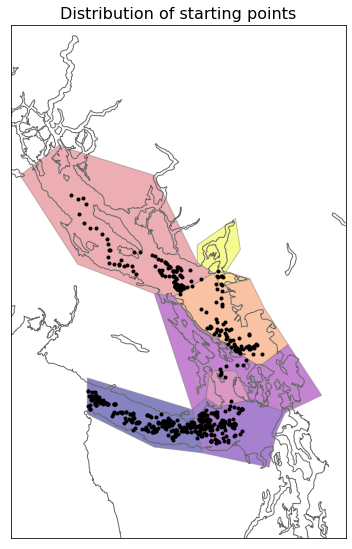

In [20]:
regions = {name: Polygon(polygons['polygon_coords'][name]) for name in polygons['polygon_coords'].keys()}
fig, ax = plt.subplots(1,1,figsize=(5,10))
m = Basemap(projection='merc',llcrnrlat=47.5,urcrnrlat=51,llcrnrlon=-125.5,urcrnrlon=-122,resolution='h',ax=ax)
regions_map = {name: [m(poly[i][1], poly[i][0])
                        for i in range(len(poly))] 
               for name, poly in polygons['polygon_coords'].items()}
n = len(regions_map.keys())
colors=[cm.plasma(np.linspace(0, 1, n))[i] for i in range(n)]
for name,color in zip(regions_map, colors):
    poly=patches.Polygon(regions_map[name], facecolor=color,edgecolor='gray', alpha=0.5)
    ax.add_patch(poly)
    region = regions[name]
    datasets_region = refine_regions(datasets_all, [region, ], include=True)
    setname = datasets_region[0].setname.values[0]
    dataset_tmp = [datasets_region[0].sel(setname=setname),]
    if len(datasets_region) > 1:
        for dataset in datasets_region[1:]:
            dataset_tmp.append(dataset.sel(setname=setname))
    num_points = plot_starting_points(ax, m, dataset_tmp,color='k')
    print('{}: num points = {}'.format(name, num_points))
m.drawcoastlines(color='dimgray',linewidth=1)
ax.set_title('Distribution of starting points',fontsize=16)
plt.tight_layout()
fig.savefig('regions-startingpoints.png')

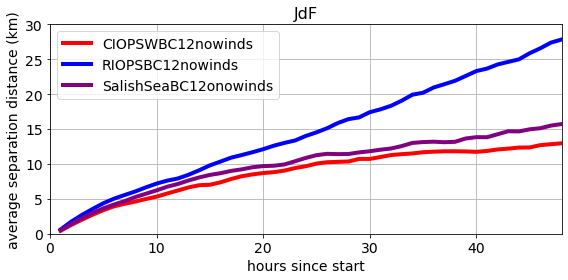

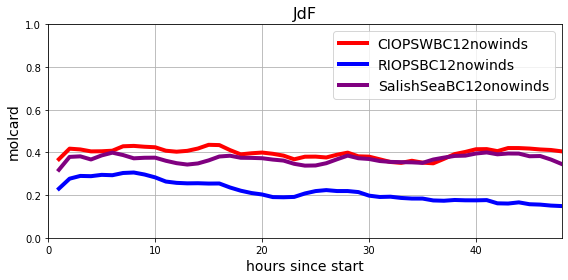

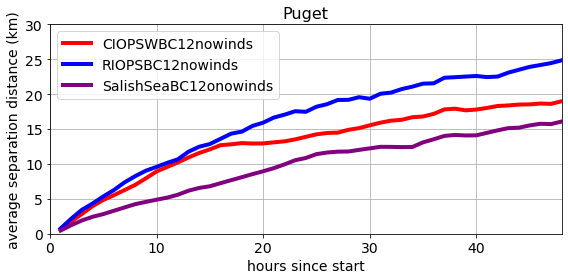

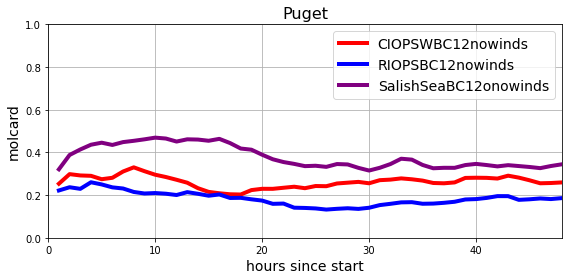

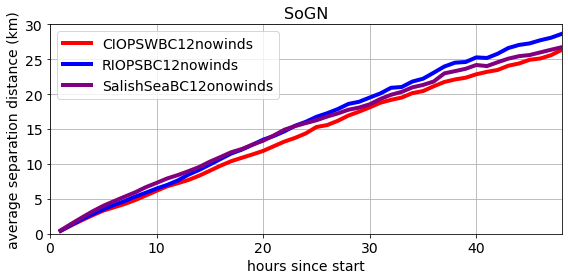

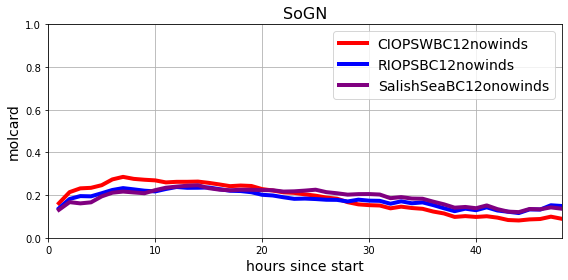

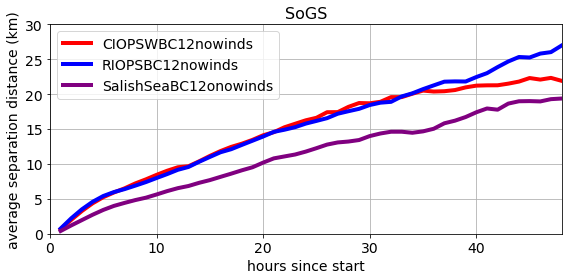

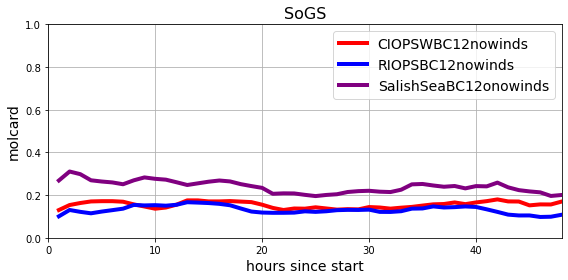

In [21]:
for region_name, region in regions.items():
    if region_name in ['VH', 'Haro', 'GulfIsl', 'Howe']:
        continue
    datasets_region = refine_regions(datasets_all, [region, ], include=True)
    dataset_per_set={}
    for setname in datasets_region[0].setname.values:
        dataset_per_set[setname] = [datasets_region[0].sel(setname=setname),]
        if len(datasets_region) > 1:
            for dataset in datasets_region[1:]:
                dataset_per_set[setname].append(dataset.sel(setname=setname))
    for skill in ['sep', 'molcard']:
        fig,ax=plt.subplots(1,1,figsize=(8,4))
        plot_skill(skill, dataset_per_set, ax, plot_iqr=False)
        ax.set_title(region_name,fontsize=16)
        ax.set_ylim([0,1])
        if skill == 'sep':
            ax.set_ylim([0, 30])
            ax.set_ylabel('average separation distance (km)',fontsize=14)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
        fname='{}_{}.png'.format(region_name, skill)
        plt.tight_layout()
        fig.savefig(fname)